# Dataset for COVID

In [2]:
from glob import glob #to retrieve array of files in directories
from tqdm import tqdm  #for progress bar
import os
import csv
import random
import pydicom #to read dicom file
import numpy as np
from skimage import io
from skimage import measure
from skimage.transform import resize
import cv2
from pathlib import Path #for path handling
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import shutil

In [38]:
#Select all of the combination of 'COVID-19' patients with 'PA' X-Ray
length = 0
metadata_dir = "..\\Input\\covid-chestxray-dataset\\metadata.csv" #NEED TO CHANGE!
imageDir = "..\\Input\\covid-chestxray-dataset\\images" #NEED TO CHANGE!

outputDir = "..\Input\\covid_img2\\" #create a new directory
os.makedirs(outputDir)

metadata_csv = pd.read_csv(metadata_dir)
dis = metadata_csv["finding"]
x_ray = metadata_csv["modality"] #useless
view = metadata_csv["view"]
name = metadata_csv["filename"]

In [64]:
metadata_csv.head(6)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN


In [11]:
metadata_csv.shape

(950, 30)

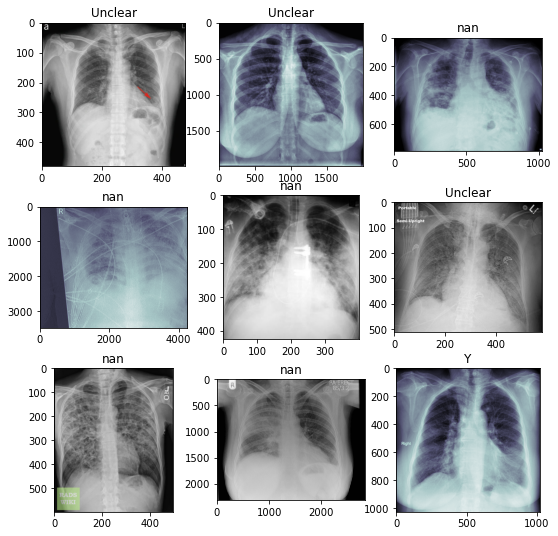

In [50]:
#create a 3x3 subplot
fig, axis = plt.subplots(3,3, figsize = (9,9))

ROOT_PATH = Path("..\\Input\\covid-chestxray-dataset\\images\\")


for i in range(3):
    for j in range(3):
        random_number = random.randint(0, 930)
        patient_id = metadata_csv.filename.iloc[random_number] #extract PID
        path = plt.imread(ROOT_PATH/patient_id)
#         dcm = read_file(dcm_path).pixel_array
        
        #store the Target in a variable
        label = metadata_csv["RT_PCR_positive"].iloc[random_number] 
            
        axis[i][j].imshow(path, cmap= "bone")
        axis[i][j].set_title(label)

In [6]:
from tensorflow.keras.preprocessing import image

covid_image = []

covid_list = []
covid_list = glob("..\\Input\\covid-chestxray-dataset\\images\\*")

for i in covid_list:
    i = i.rsplit("\\", 1)[-1]
    covid_image.append(i)

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in tqdm(list_of_filename):
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
covid_images = img2np("..\\Input\\covid-chestxray-dataset\\images\\", covid_image)

100%|██████████| 930/930 [00:52<00:00, 17.61it/s]


In [7]:
covid_images

array([[  1.,   1.,   1., ..., 201., 202., 205.],
       [ 89.,  67.,  97., ...,   1.,   1.,   1.],
       [ 59.,  89., 113., ...,   0.,   0.,   0.],
       ...,
       [ 40.,  41.,  45., ...,  67.,  24.,  29.],
       [ 28.,  40.,  52., ..., 114., 125., 113.],
       [ 31.,  29.,  30., ..., 141., 116.,  98.]], dtype=float32)

In [8]:
covid_images.shape

(930, 4096)

In [9]:
covid_images.size

3809280

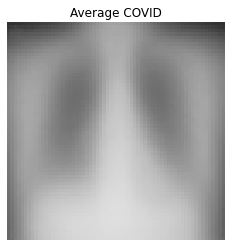

In [87]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(covid_images, 'COVID')

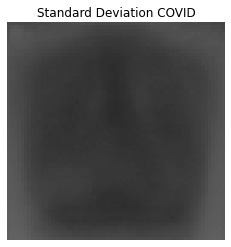

In [88]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(covid_images, 'COVID')

Number of PC:  11


100%|██████████| 11/11 [00:00<00:00, 46.61it/s]


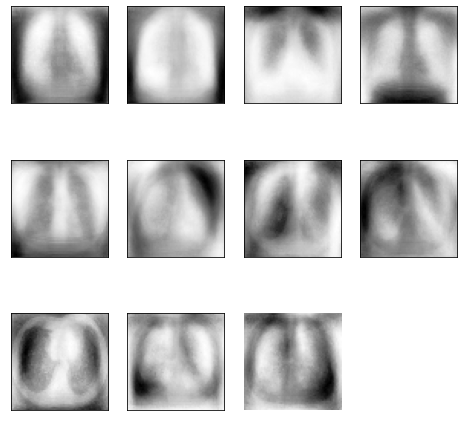

In [89]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in tqdm(range(n)):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(covid_images, 'COVID'))

In [56]:
metadata_csv.head(30)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
5,4,5.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 30, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1b.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive diffuse interstitial opacities and...,NaN,NaN
6,5,NaN,NaN,NaN,Pneumonia,NaN,NaN,Y,Y,Y,...,2017,NaN,images,ARDSSevere.png,NaN,https://en.wikipedia.org/wiki/File:ARDSSevere.png,CC BY-SA,Severe ARDS. Person is intubated with an OG in...,NaN,NaN
7,6,0.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 6, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2a.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
8,6,4.0,NaN,NaN,Pneumonia/Viral/COVID-19,Y,NaN,Y,Y,Y,...,"January 10, 2020","Wuhan Jinyintan Hospital, Wuhan, Hubei Provinc...",images,lancet-case2b.jpg,10.1016/S0140-6736(20)30211-7,https://www.thelancet.com/journals/lancet/arti...,NaN,Case 2: chest x-ray obtained on Jan 6 (2A). Th...,NaN,NaN
9,3,4.0,M,74.0,Pneumonia/Viral/SARS,NaN,N,NaN,NaN,NaN,...,2004,"Mount Sinai Hospital, Toronto, Ontario, Canada",images,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,NaN,SARS in a 74-year-old man who developed sympto...,NaN,NaN


Text(0.5, 1.0, 'Number of Patients Diagnosed with COVID-19')

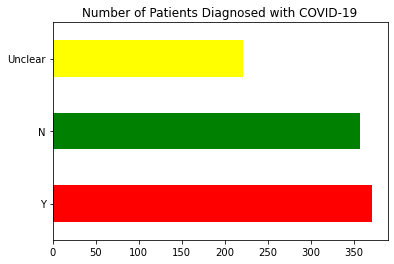

In [74]:
metadata_csv['RT_PCR_positive'] =metadata_csv['RT_PCR_positive'].fillna('N')


fig, ax = plt.subplots()
c = ['red', 'green', 'yellow']
metadata_csv["RT_PCR_positive"].value_counts().plot(ax=ax, kind="barh", color= c)
plt.title("Number of Patients Diagnosed with COVID-19")

<AxesSubplot:xlabel='sex'>

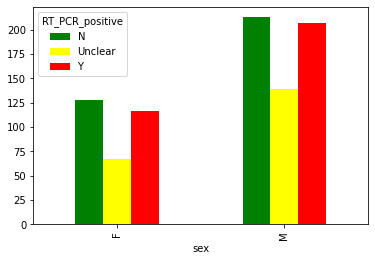

In [32]:
c= ['green', 'yellow', 'red']
CrosstabResult=pd.crosstab(index=metadata_csv['sex'],columns=metadata_csv['RT_PCR_positive'])
CrosstabResult.plot.bar(color= c)

In [72]:
bins= [0,2,16,30,45,100]
labels = ['babies', 'childeren', 'youngAdult', 'middleAdult', 'oldAdult']

metadata_csv['AgeGroup'] = pd.cut(metadata_csv['age'], bins=bins, labels=labels, right=False)


<AxesSubplot:ylabel='AgeGroup'>

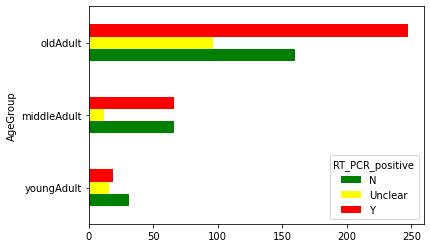

In [75]:
c= ['green', 'yellow', 'red']
CrosstabResult=pd.crosstab(index=metadata_csv['AgeGroup'],columns=metadata_csv['RT_PCR_positive'])
CrosstabResult.plot.barh(color= c)

In [80]:
# loop over the rows of the COVID-19 dataFrame
for i in range(len(metadata_csv)):
    if dis[i] == "COVID-19" and view[i] == "PA":
        shutil.copy(imageDir+name[i],outputDir+name[i])        
        length += 1

# Dataset 2

In [22]:
#for Figure1-COVID chestray-dataset

meta = pd.read_csv("..\\Input\\Figure1-COVID-chestxray-dataset\\metadata.csv", encoding='ISO-8859-1')
fig1_imgpath = "..\Input\\Figure1-COVID-chestxray-dataset\\images\\"
dis = meta["finding"]
patientid = meta["patientid"]



In [23]:
meta.head(5)

,patientid,offset,sex,age,finding,survival,temperature,pO2 saturation,view,modality,artifacts/distortion,notes
0,COVID-00001,13.0,M,33.0,COVID-19,NaN,NaN,58,AP erect,X-ray,NaN,O2 saturation was initially 58% on room air an...
1,COVID-00002,NaN,M,50.0,NaN,NaN,NaN,NaN,AP erect,X-ray,NaN,"50+ male patient, asthmatic, returning from a ..."
2,COVID-00003a,8.0,M,28.0,NaN,NaN,39.1,90,AP erect,X-ray,NaN,"28M previously fit and well, not on any regula..."
3,COVID-00003b,8.0,M,28.0,NaN,NaN,39.1,90,AP erect,X-ray,NaN,Post-intubation in the critical care setting
4,COVID-00004,2.0,M,42.0,COVID-19,NaN,NaN,91-92,PA,X-ray,NaN,42 year old male patient presented to ED with ...


In [7]:
meta.isnull().sum()

patientid                0
offset                  35
sex                     33
age                     26
finding                 15
survival                55
temperature             51
pO2 saturation          43
view                    37
modality                 0
artifacts/distortion    48
notes                    7
dtype: int64

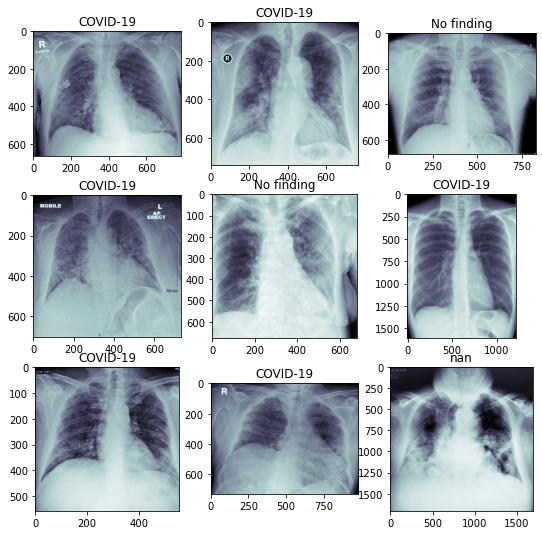

In [108]:
#create a 3x3 subplot
fig, axis = plt.subplots(3,3, figsize = (9,9))

ROOT_PATH = Path("..\Input\\Figure1-COVID-chestxray-dataset\\images\\")


for i in range(3):
    for j in range(3):
        random_number = random.randint(0, 55)
        
        try:
            patient_id = meta.patientid.iloc[random_number] + ".jpg"#extract PID 
        except:
            patient_id = meta.patientid.iloc[random_number] + ".png"
            
        path = plt.imread(ROOT_PATH/patient_id)
#         dcm = read_file(dcm_path).pixel_array
        
        #store the Target in a variable
        label = meta["finding"].iloc[random_number] 
            
        axis[i][j].imshow(path, cmap= "bone")
        axis[i][j].set_title(label)

In [113]:
from tensorflow.keras.preprocessing import image

covid_image2 = []

covid_list2 = []
covid_list2 = glob("..\Input\\Figure1-COVID-chestxray-dataset\\images\\*")

for i in covid_list2:
    i = i.rsplit("\\", 1)[-1]
    covid_image2.append(i)

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in tqdm(list_of_filename):
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
covid_images2 = img2np("..\Input\\Figure1-COVID-chestxray-dataset\\images\\", covid_image2)

100%|██████████| 55/55 [00:01<00:00, 37.65it/s]


In [114]:
covid_images2

array([[ 20.,  15.,  13., ..., 188., 203., 188.],
       [ 61.,  67.,  71., ..., 143., 144., 131.],
       [ 13.,  17.,  20., ...,  97., 109., 116.],
       ...,
       [ 84., 108., 147., ...,  87.,  70.,   4.],
       [ 45.,  42.,  42., ..., 143., 100.,  68.],
       [ 91.,  68.,  57., ...,  14.,  18.,  15.]], dtype=float32)

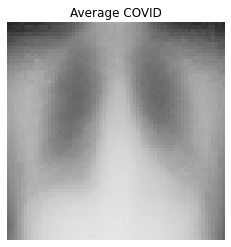

In [115]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(covid_images2, 'COVID')

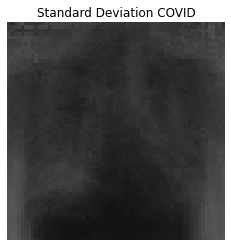

In [116]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(covid_images2, 'COVID')

Number of PC:  8


100%|██████████| 8/8 [00:00<00:00, 46.24it/s]


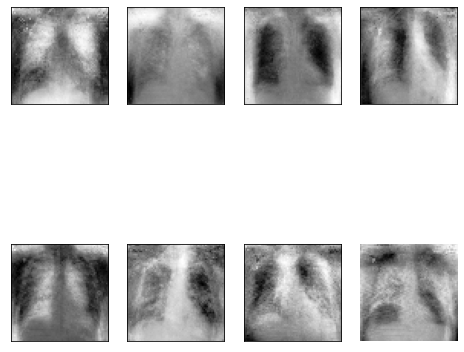

In [135]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in tqdm(range(n)):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(covid_images2, 'COVID'))

In [5]:
meta

,patientid,offset,sex,age,finding,survival,temperature,pO2 saturation,view,modality,artifacts/distortion,notes
0,COVID-00001,13.0,M,33,COVID-19,NaN,NaN,58,AP erect,X-ray,NaN,O2 saturation was initially 58% on room air an...
1,COVID-00002,NaN,M,50+,NaN,NaN,NaN,NaN,AP erect,X-ray,NaN,"50+ male patient, asthmatic, returning from a ..."
2,COVID-00003a,8.0,M,28,NaN,NaN,39.1,90,AP erect,X-ray,NaN,"28M previously fit and well, not on any regula..."
3,COVID-00003b,8.0,M,28,NaN,NaN,39.1,90,AP erect,X-ray,NaN,Post-intubation in the critical care setting
4,COVID-00004,2.0,M,42,COVID-19,NaN,NaN,91-92,PA,X-ray,NaN,42 year old male patient presented to ED with ...
5,COVID-00005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X-ray,"Slight from monitor, red blur on bottom left c...",NaN
6,COVID-00006,5.0,F,57,COVID-19,NaN,NaN,NaN,NaN,X-ray,Some from monitor,57 year old female. Returning from Texas March...
7,COVID-00007,NaN,NaN,73,NaN,NaN,38+,NaN,NaN,X-ray,"Some from monitor, slight uneven colour tint",73 yo. No antecedents. Fever 38° + cough. Seve...
8,COVID-00008,4.0,M,47,COVID-19,NaN,NaN,92,AP erect,X-ray,"Some from monitor, dust specks, cropped out mo...","47 Male, BMI 34, sleep apnea and childhood ast..."
9,COVID-00009,NaN,NaN,NaN,COVID-19,NaN,NaN,NaN,NaN,X-ray,"Some from monitor, oversaturation at bottom",CXray during worsening corona infection


Text(0.5, 1.0, 'Number of Patients Diagnosed with COVID-19')

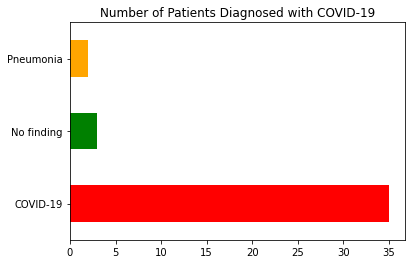

In [24]:
fig, ax = plt.subplots()
c = ['red', 'green', 'orange']
meta["finding"].value_counts().plot(ax=ax, kind="barh", color= c)
plt.title("Number of Patients Diagnosed with COVID-19")

<AxesSubplot:xlabel='sex'>

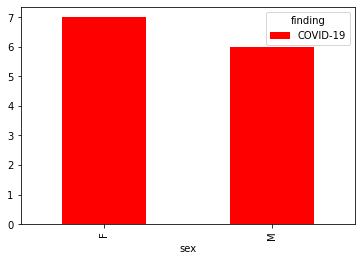

In [30]:
c= ['red']
CrosstabResult=pd.crosstab(index=meta['sex'],columns=meta['finding'])
CrosstabResult.plot.bar(color = c)

In [26]:
bins= [0,2,16,30,45,100]
labels = ['babies', 'childeren', 'youngAdult', 'middleAdult', 'oldAdult']

meta['AgeGroup'] = pd.cut(meta['age'], bins=bins, labels=labels, right=False)


<AxesSubplot:ylabel='AgeGroup'>

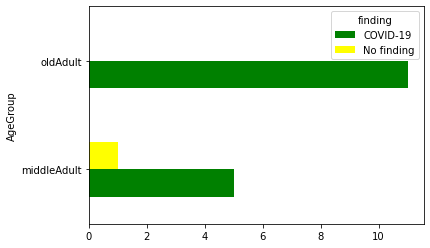

In [27]:
c= ['green', 'yellow', 'red']
CrosstabResult=pd.crosstab(index=meta['AgeGroup'],columns=meta['finding'])
CrosstabResult.plot.barh(color= c)

In [ ]:
for i in range(len(dis)):
    if dis[i] == "COVID-19":
        try:
            shutil.copy(fig1_imgpath + patientid[i]+ ".jpg", outputDir + patientid[i] + ".jpg")
        except:
            shutil.copy(fig1_imgpath + patientid[i]+".png",outputDir+patientid[i]+".png")
        length +=1

# Dataset 3

In [31]:
#FOR ACTUALMED-COVID-CHESTRAY-DATASET
actmed_csvpath = "..\\Input\\Actualmed-COVID-chestxray-dataset\\metadata.csv"
actmed_csv = pd.read_csv(actmed_csvpath, nrows= None)
actmed_imgpath = "..\\Input\\Actualmed-COVID-chestxray-dataset\\images\\"

actmed_dis = actmed_csv["finding"]
actmed_imgname = actmed_csv["imagename"]


In [32]:
actmed_csv.head(5)

,patientid,offset,sex,age,finding,survival,temperature,pO2 saturation,view,modality,imagename,artifacts/distortion,notes
0,ANON196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200313090023421...,NaN,"Inconclusive, date taken (YYYYMMDD): 20200313"
1,ANON196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200313100318375...,NaN,"Inconclusive, date taken (YYYYMMDD): 20200313"
2,ANON56,NaN,NaN,NaN,No finding,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200317090830828...,NaN,Negative (covid-19 viral infection is excluded...
3,ANON56,NaN,NaN,NaN,No finding,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200317104341875...,NaN,Negative (covid-19 viral infection is excluded...
4,ANON196,NaN,NaN,NaN,COVID-19,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200318082923328...,NaN,", date taken (YYYYMMDD): 20200318"


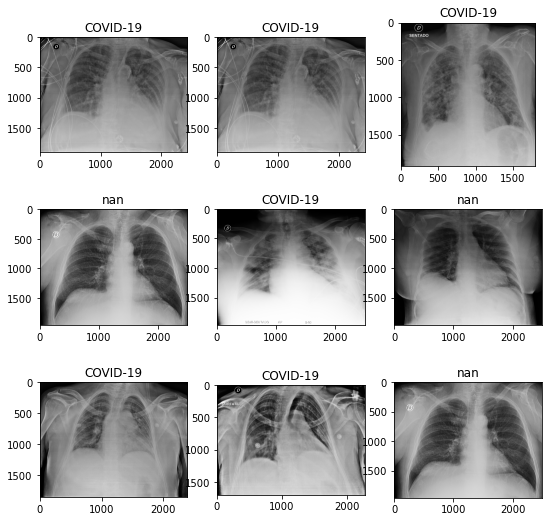

In [126]:
#create a 3x3 subplot
fig, axis = plt.subplots(3,3, figsize = (9,9))

ROOT_PATH = Path("..\\Input\\Actualmed-COVID-chestxray-dataset\\images\\")


for i in range(3):
    for j in range(3):
        random_number = random.randint(0, 238)
        
        patient_id = actmed_csv.imagename.iloc[random_number]#extract PID 
            
        path = plt.imread(ROOT_PATH/patient_id)
#         dcm = read_file(dcm_path).pixel_array
        
        #store the Target in a variable
        label = actmed_csv["finding"].iloc[random_number] 
            
        axis[i][j].imshow(path, cmap= "bone")
        axis[i][j].set_title(label)

In [130]:
from tensorflow.keras.preprocessing import image

covid_image3 = []

covid_list3 = []
covid_list3 = glob("..\\Input\\Actualmed-COVID-chestxray-dataset\\images\\*")

for i in covid_list3:
    i = i.rsplit("\\", 1)[-1]
    covid_image3.append(i)

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in tqdm(list_of_filename):
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
covid_images3 = img2np("..\\Input\\Actualmed-COVID-chestxray-dataset\\images\\", covid_image3)

100%|██████████| 238/238 [00:22<00:00, 10.44it/s]


In [131]:
covid_images3

array([[ 16.,  12.,  12., ..., 135., 112.,  70.],
       [ 40.,  22.,  17., ...,   2.,   3.,   6.],
       [ 21.,  15.,  10., ..., 200., 127.,  61.],
       ...,
       [ 42.,  55.,  63., ...,  47.,   9.,  12.],
       [ 24.,  21.,  20., ...,  34.,  32.,  35.],
       [ 18.,  15.,  28., ..., 132.,  95.,  66.]], dtype=float32)

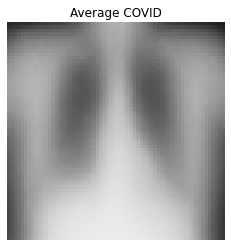

In [133]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(covid_images3, 'COVID')

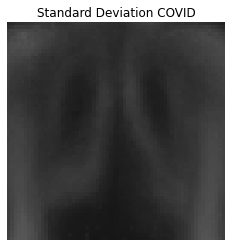

In [134]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(covid_images3, 'COVID')

Number of PC:  9


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


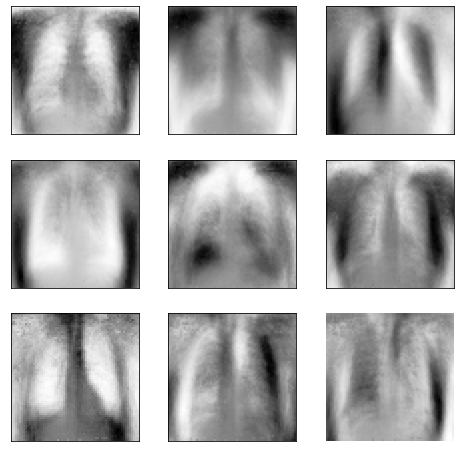

In [136]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in tqdm(range(n)):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(covid_images3, 'COVID'))

In [33]:
actmed_csv.head(5)

,patientid,offset,sex,age,finding,survival,temperature,pO2 saturation,view,modality,imagename,artifacts/distortion,notes
0,ANON196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200313090023421...,NaN,"Inconclusive, date taken (YYYYMMDD): 20200313"
1,ANON196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200313100318375...,NaN,"Inconclusive, date taken (YYYYMMDD): 20200313"
2,ANON56,NaN,NaN,NaN,No finding,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200317090830828...,NaN,Negative (covid-19 viral infection is excluded...
3,ANON56,NaN,NaN,NaN,No finding,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200317104341875...,NaN,Negative (covid-19 viral infection is excluded...
4,ANON196,NaN,NaN,NaN,COVID-19,NaN,NaN,NaN,PA,X-ray,CR.1.2.840.113564.1722810170.20200318082923328...,NaN,", date taken (YYYYMMDD): 20200318"


Text(0.5, 1.0, 'Number of Patients Diagnosed with COVID-19')

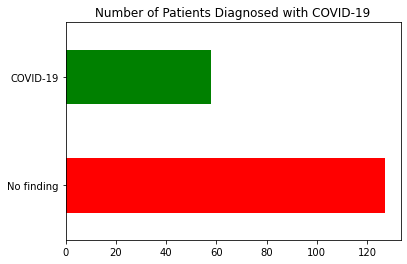

In [34]:
fig, ax = plt.subplots()
c = ['red', 'green', 'orange']
actmed_csv["finding"].value_counts().plot(ax=ax, kind="barh", color= c)
plt.title("Number of Patients Diagnosed with COVID-19")

In [ ]:
for i in range(len(dis)):
    if actmed_dis[i] == "COVID-19":
        shutil.copy(actmed_imgpath + actmed_imgname[i], outputDir + actmed_imgname[i])
        length +=1

# Dataset 4

In [39]:
#FOR COVID19-RADIOGRAPHY-DATABASE
rad_csv_dir = "..\\Input\\COVID-19_Radiography_Dataset\\COVID.metadata.xlsx"
rad_csv = pd.read_excel(rad_csv_dir)
rad_impath = "..\\Input\\COVID-19_Radiography_Dataset\\COVID\\images\\"
rad_patientid = rad_csv['FILE NAME']

url1 = rad_csv['URL']
url2 = metadata_csv['url']



In [40]:
rad_csv.head(6)

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
5,COVID-6,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


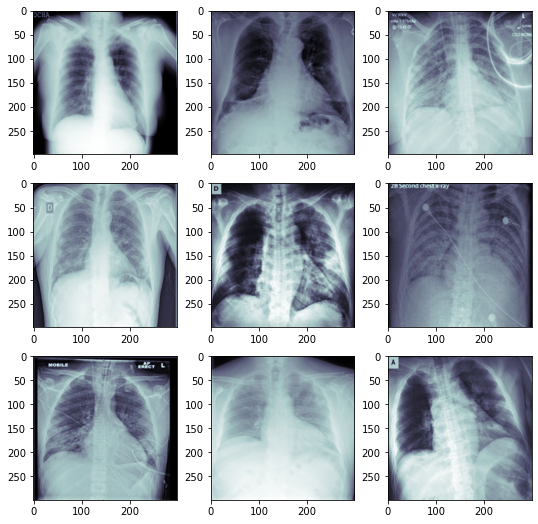

In [143]:
#create a 3x3 subplot
fig, axis = plt.subplots(3,3, figsize = (9,9))

ROOT_PATH = Path(rad_impath)

rad_csv.rename(columns = {'FILE NAME':'FileName'}, inplace = True)


for i in range(3):
    for j in range(3):
        random_number = random.randint(0, 3616)
        patient_id = rad_csv.FileName.iloc[random_number] + ".png"#extract PID 
        path = plt.imread(ROOT_PATH/patient_id)
        axis[i][j].imshow(path, cmap= "bone")


In [145]:
from tensorflow.keras.preprocessing import image

covid_image4 = []

covid_list4 = []
covid_list4 = glob("..\\Input\\COVID-19_Radiography_Dataset\\COVID\\images\\*")

for i in covid_list4:
    i = i.rsplit("\\", 1)[-1]
    covid_image4.append(i)

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in tqdm(list_of_filename):
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
covid_images4 = img2np("..\\Input\\COVID-19_Radiography_Dataset\\COVID\\images\\", covid_image4)

100%|██████████| 3616/3616 [02:23<00:00, 25.25it/s]


In [146]:
covid_images4

array([[  0.,   0.,   1., ...,   0.,  14.,   3.],
       [125., 123., 121., ..., 171., 165., 161.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  4.,   1.,   0., ...,  65., 105., 202.],
       [  0.,   0.,   0., ...,  69.,  65.,  61.],
       [ 26.,  31.,  31., ..., 156., 144., 107.]], dtype=float32)

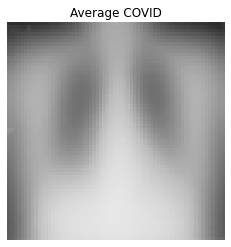

In [147]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(covid_images4, 'COVID')

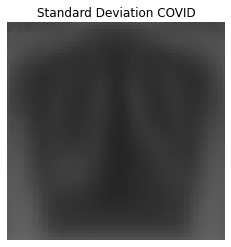

In [148]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(covid_images4, 'COVID')

Number of PC:  9


100%|██████████| 9/9 [00:00<00:00, 38.37it/s]


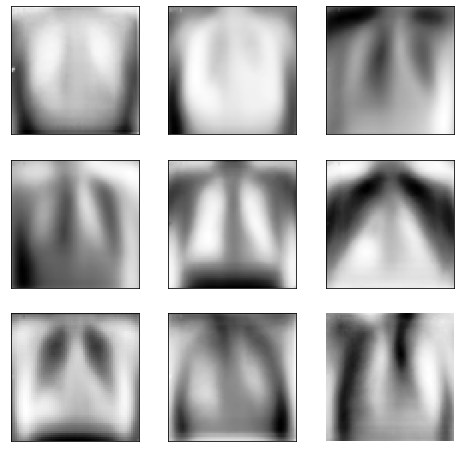

In [149]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in tqdm(range(n)):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(covid_images4, 'COVID'))

In [ ]:
#Discard the images which already presented through covid-chestray-dataset
discard = ['100', '101', '102', '103', '104', '105', 
           '110', '111', '112', '113', '122', '123', 
           '124', '125', '126', '217']

for i in range(len(rad_patientid)):
    if url1[i] not in url2 and rad_patientid[i][rad_patientid[i].find('(')+1: rad_patientid[i].find(')')] not in discard: #removes duplicates
        try:
            shutil.copy(rad_impath + rad_patientid[i] + ".png", outputDir + rad_patientid[i] + ".png")
        except:
            name = rad_patientid[i].split("(")
            name = name[0] + "(" + name[1]
            shutil.copy(rad_impath + name + ".png", outputDir + name + ".png")
        length+=1

# Merge all datasets

In [8]:
final_dir = "proc_input\\covid_data\\"

try:
    os.makedirs(final_dir+ "train/COVID/")
    os.makedirs(final_dir+ "test/COVID/")
except:
    pass

In [9]:
total = os.listdir(outputDir)
random.shuffle(total)

for i in tqdm(total[int(length)-100:]):
    shutil.copy(outputDir + i,final_dir + "test/COVID/" + i)

for i in tqdm(total[:int (length)-100]):
    shutil.copy(outputDir + i, final_dir + "train/COVID/" + i)

100%|██████████| 3585/3585 [00:10<00:00, 342.07it/s]
